# XGBoost Regression - Model

This is the implementation of an Extreme Gradient Boost Regression Model as an alternative to the Linear Regression Model that served as a baseline performance.

For this model, different tuning techniques were used in order to improve upon the model's metrics.

## Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')
pd.options.display.float_format = '{:.4f}'.format
rc={'savefig.dpi': 75, 'figure.autolayout': False, 'figure.figsize': [12, 8], 'axes.labelsize': 18,\
   'axes.titlesize': 18, 'font.size': 18, 'lines.linewidth': 2.0, 'lines.markersize': 8, 'legend.fontsize': 16,\
   'xtick.labelsize': 16, 'ytick.labelsize': 16}

sns.set(style='dark',rc=rc)

pd.options.display.max_rows = 400
pd.options.display.max_seq_items = 200

default_color = '#56B4E9'
colormap = plt.cm.cool

In [2]:
import xgboost
from sklearn.model_selection import KFold, cross_validate, GridSearchCV

# Loading Data

In [3]:
df_1_all = pd.read_csv('Cleaned Data/df_1_all_reg.csv')
df_2_all = pd.read_csv('Cleaned Data/df_2_all_reg.csv')
df_3_all = pd.read_csv('Cleaned Data/df_3_all_reg.csv')
df_4_all = pd.read_csv('Cleaned Data/df_4_all_reg.csv')
df_5_all = pd.read_csv('Cleaned Data/df_5_all_reg.csv')
df_6_all = pd.read_csv('Cleaned Data/df_6_all_reg.csv')

In [4]:
df_1_2017 = pd.read_csv('Cleaned Data/df_1_2017_reg.csv')
df_2_2017 = pd.read_csv('Cleaned Data/df_2_2017_reg.csv')
df_3_2017 = pd.read_csv('Cleaned Data/df_3_2017_reg.csv')
df_4_2017 = pd.read_csv('Cleaned Data/df_4_2017_reg.csv')
df_5_2017 = pd.read_csv('Cleaned Data/df_5_2017_reg.csv')
df_6_2017 = pd.read_csv('Cleaned Data/df_6_2017_reg.csv')

## Utilitary Functions and Variables

In [5]:
'''
Cross Validation Function
Takes in training set features and target, the model, and number of splits for K-Fold, 
returns the mean of the K scores.

'''
def cross_val(X, y, model):
    kfold = KFold(n_splits=5, random_state=seed, shuffle = True)
    results = cross_validate(model, X, y, cv=kfold, scoring=scoring)
    print('MAE: %.4f (%.4f)' % (results['test_MAE'].mean()*-1, results['test_MAE'].std()))
    print('MSE: %.4f (%.4f)' % (results['test_MSE'].mean()*-1, results['test_MSE'].std()))
    print('-----------------------------------------')

In [6]:
'''
Plot Figure Helper Function
Takes in the predicted scores and original target scores and returns a graph.

'''
def plot_figure(scores, pred):
    plt.figure(figsize=(16,6))
    plt.plot(range(scores.shape[0]), scores, color='royalblue', alpha=.8, label='True')
    plt.plot(range(pred.shape[0]), pred, color='tomato', alpha=.8, label='Predicted')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title("Predicted vs True Values")
    plt.xlabel("Entries")
    plt.ylabel("Points")

In [7]:
'''
Show Predictions Function
Takes in the model, training set features and target, and the original dataframe, 
returns a graph with the predicted values as compared to the original target values.

'''
def show_preds(estimator, X, y, df):
    pred = estimator.predict(X)
    df['predictions'] = pred
    plot_figure(y, pred)
    #return df[['Athlete_Name', 'Pontos', 'predictions', 'Preco', 'Rodada']].sort_values(by=['predictions'], ascending=False)

In [8]:
'''
Prediction Function
Takes in Dataframe, Model, Model Parameters, number of players per position, and returns a list with 
the following features: Athlete ID, Position ID, Points, Round, Predicted Scores, Price, and Price Variation
for the chosen athletes.

'''
def get_preds(df, model, model_params, count):
    lst = []
    for rodada in list_rounds:
        df_rodada = df[df.Round == rodada]
        df_rodada['predictions'] = model.predict(df_rodada[model_params].as_matrix())
        df_sorted = df_rodada.sort_values(by=['predictions'], ascending=False).head(count)
        for i in range(count):
            lst.append([df_sorted.AthleteID.values[i], df_sorted.PositionID.values[i], 
                        df_sorted.Points.values[i], rodada, df_sorted.predictions.values[i],
                        df_sorted.Price.values[i], df_sorted.Price_Variation.values[i]])
    return lst

In [9]:
seed = 42
np.random.seed(seed)

In [10]:
# Scoring Functions for the Regressor
scoring = {'MAE': 'neg_mean_absolute_error',
           'MSE': 'neg_mean_squared_error'}

In [12]:
base_params = ['Away', 'avg_Assists',
       'avg_Difficult_Saves', 'avg_Fouls_Conceded', 'avg_Fouls_Received',
       'avg_Game_Without_Being_Scored', 'avg_Goals', 'avg_Goals_Conceded',
       'avg_Missed_Passes', 'avg_Missed_Penalty', 'avg_Offsides',
       'avg_Own_Goals', 'avg_Penalty_Saves', 'avg_Points', 'avg_Price',
       'avg_Red_Card', 'avg_Shot_Missed', 'avg_Shot_Saved',
       'avg_Shot_on_Post', 'avg_Stolen_Balls', 'avg_Yellow_Card',
               
       'avg_team_avg_1_Difficult_Saves', 'avg_team_avg_1_Points',
       'avg_team_avg_1_Assists', 'avg_team_avg_1_Fouls_Conceded',
       'avg_team_avg_1_Fouls_Received',
       'avg_team_avg_1_Game_Without_Being_Scored',
       'avg_team_avg_1_Goals_Conceded', 'avg_team_avg_1_Missed_Passes',
       'avg_team_avg_1_Penalty_Saves', 'avg_team_avg_1_Price',
       'avg_team_avg_1_Red_Card', 'avg_team_avg_1_Shot_Saved',
       'avg_team_avg_1_Stolen_Balls', 'avg_team_avg_1_Yellow_Card',
               
       'avg_team_avg_2_Assists', 'avg_team_avg_2_Fouls_Conceded',
       'avg_team_avg_2_Fouls_Received',
       'avg_team_avg_2_Game_Without_Being_Scored', 'avg_team_avg_2_Goals',
       'avg_team_avg_2_Missed_Passes', 'avg_team_avg_2_Missed_Penalty',
       'avg_team_avg_2_Offsides', 'avg_team_avg_2_Own_Goals',
       'avg_team_avg_2_Price', 'avg_team_avg_2_Points',
       'avg_team_avg_2_Red_Card', 'avg_team_avg_2_Shot_Missed',
       'avg_team_avg_2_Shot_Saved', 'avg_team_avg_2_Shot_on_Post',
       'avg_team_avg_2_Stolen_Balls', 'avg_team_avg_2_Yellow_Card',
               
       'avg_team_avg_3_Assists', 'avg_team_avg_3_Fouls_Conceded',
       'avg_team_avg_3_Fouls_Received',
       'avg_team_avg_3_Game_Without_Being_Scored', 'avg_team_avg_3_Goals',
       'avg_team_avg_3_Missed_Passes', 'avg_team_avg_3_Missed_Penalty',
       'avg_team_avg_3_Offsides', 'avg_team_avg_3_Own_Goals',
       'avg_team_avg_3_Points', 'avg_team_avg_3_Price',
       'avg_team_avg_3_Red_Card', 'avg_team_avg_3_Shot_Missed',
       'avg_team_avg_3_Shot_Saved', 'avg_team_avg_3_Shot_on_Post',
       'avg_team_avg_3_Stolen_Balls', 'avg_team_avg_3_Yellow_Card',
               
       'avg_team_avg_4_Assists', 'avg_team_avg_4_Fouls_Conceded',
       'avg_team_avg_4_Fouls_Received',
       'avg_team_avg_4_Game_Without_Being_Scored', 'avg_team_avg_4_Goals',
       'avg_team_avg_4_Missed_Passes', 'avg_team_avg_4_Missed_Penalty',
       'avg_team_avg_4_Offsides', 'avg_team_avg_4_Own_Goals',
       'avg_team_avg_4_Points', 'avg_team_avg_4_Price',
       'avg_team_avg_4_Red_Card', 'avg_team_avg_4_Shot_Missed',
       'avg_team_avg_4_Shot_Saved', 'avg_team_avg_4_Shot_on_Post',
       'avg_team_avg_4_Stolen_Balls', 'avg_team_avg_4_Yellow_Card',
               
       'avg_team_avg_5_Assists', 'avg_team_avg_5_Fouls_Conceded',
       'avg_team_avg_5_Fouls_Received',
       'avg_team_avg_5_Game_Without_Being_Scored', 'avg_team_avg_5_Goals',
       'avg_team_avg_5_Missed_Passes', 'avg_team_avg_5_Missed_Penalty',
       'avg_team_avg_5_Offsides', 'avg_team_avg_5_Own_Goals',
       'avg_team_avg_5_Points', 'avg_team_avg_5_Price',
       'avg_team_avg_5_Red_Card', 'avg_team_avg_5_Shot_Missed',
       'avg_team_avg_5_Shot_Saved', 'avg_team_avg_5_Shot_on_Post',
       'avg_team_avg_5_Stolen_Balls', 'avg_team_avg_5_Yellow_Card',
               
       'avg_team_avg_6_Points', 'avg_team_avg_6_Price',
               
       'opp_avg_team_avg_1_Difficult_Saves', 'opp_avg_team_avg_1_Points',
       'opp_avg_team_avg_1_Assists', 'opp_avg_team_avg_1_Fouls_Conceded',
       'opp_avg_team_avg_1_Fouls_Received',
       'opp_avg_team_avg_1_Game_Without_Being_Scored',
       'opp_avg_team_avg_1_Goals_Conceded',
       'opp_avg_team_avg_1_Missed_Passes',
       'opp_avg_team_avg_1_Penalty_Saves', 'opp_avg_team_avg_1_Price',
       'opp_avg_team_avg_1_Red_Card', 'opp_avg_team_avg_1_Shot_Saved',
       'opp_avg_team_avg_1_Stolen_Balls', 'opp_avg_team_avg_1_Yellow_Card',
               
       'opp_avg_team_avg_2_Assists', 'opp_avg_team_avg_2_Fouls_Conceded',
       'opp_avg_team_avg_2_Fouls_Received',
       'opp_avg_team_avg_2_Game_Without_Being_Scored',
       'opp_avg_team_avg_2_Goals', 'opp_avg_team_avg_2_Missed_Passes',
       'opp_avg_team_avg_2_Missed_Penalty', 'opp_avg_team_avg_2_Offsides',
       'opp_avg_team_avg_2_Own_Goals', 'opp_avg_team_avg_2_Price',
       'opp_avg_team_avg_2_Points', 'opp_avg_team_avg_2_Red_Card',
       'opp_avg_team_avg_2_Shot_Missed', 'opp_avg_team_avg_2_Shot_Saved',
       'opp_avg_team_avg_2_Shot_on_Post',
       'opp_avg_team_avg_2_Stolen_Balls', 'opp_avg_team_avg_2_Yellow_Card',
               
       'opp_avg_team_avg_3_Assists', 'opp_avg_team_avg_3_Fouls_Conceded',
       'opp_avg_team_avg_3_Fouls_Received',
       'opp_avg_team_avg_3_Game_Without_Being_Scored',
       'opp_avg_team_avg_3_Goals', 'opp_avg_team_avg_3_Missed_Passes',
       'opp_avg_team_avg_3_Missed_Penalty', 'opp_avg_team_avg_3_Offsides',
       'opp_avg_team_avg_3_Own_Goals', 'opp_avg_team_avg_3_Points',
       'opp_avg_team_avg_3_Price', 'opp_avg_team_avg_3_Red_Card',
       'opp_avg_team_avg_3_Shot_Missed', 'opp_avg_team_avg_3_Shot_Saved',
       'opp_avg_team_avg_3_Shot_on_Post',
       'opp_avg_team_avg_3_Stolen_Balls', 'opp_avg_team_avg_3_Yellow_Card',
               
       'opp_avg_team_avg_4_Assists', 'opp_avg_team_avg_4_Fouls_Conceded',
       'opp_avg_team_avg_4_Fouls_Received',
       'opp_avg_team_avg_4_Game_Without_Being_Scored',
       'opp_avg_team_avg_4_Goals', 'opp_avg_team_avg_4_Missed_Passes',
       'opp_avg_team_avg_4_Missed_Penalty', 'opp_avg_team_avg_4_Offsides',
       'opp_avg_team_avg_4_Own_Goals', 'opp_avg_team_avg_4_Points',
       'opp_avg_team_avg_4_Price', 'opp_avg_team_avg_4_Red_Card',
       'opp_avg_team_avg_4_Shot_Missed', 'opp_avg_team_avg_4_Shot_Saved',
       'opp_avg_team_avg_4_Shot_on_Post',
       'opp_avg_team_avg_4_Stolen_Balls', 'opp_avg_team_avg_4_Yellow_Card',
               
       'opp_avg_team_avg_5_Assists', 'opp_avg_team_avg_5_Fouls_Conceded',
       'opp_avg_team_avg_5_Fouls_Received',
       'opp_avg_team_avg_5_Game_Without_Being_Scored',
       'opp_avg_team_avg_5_Goals', 'opp_avg_team_avg_5_Missed_Passes',
       'opp_avg_team_avg_5_Missed_Penalty', 'opp_avg_team_avg_5_Offsides',
       'opp_avg_team_avg_5_Own_Goals', 'opp_avg_team_avg_5_Points',
       'opp_avg_team_avg_5_Price', 'opp_avg_team_avg_5_Red_Card',
       'opp_avg_team_avg_5_Shot_Missed', 'opp_avg_team_avg_5_Shot_Saved',
       'opp_avg_team_avg_5_Shot_on_Post',
       'opp_avg_team_avg_5_Stolen_Balls', 'opp_avg_team_avg_5_Yellow_Card',
               
       'opp_avg_team_avg_6_Points', 'opp_avg_team_avg_6_Price'
       ]

# Implementation

**XGBoost Model implementation for each position.**

Each implementation follows the followng steps: 
1. An initial filter of features is made in order to only keep the features that have valid values for the training and testing set.
2. The baseline model is defined.
3. A cross-validation of the model is done using the K-Fold split strategy, recording the corresponding MAE and MSE.
4. The model is fitted to the data.
5. A graph is drawn showing the predicted Scores as compared to the true Scores for the training set, for visualization purposes.

This process is repeated for every position.

## Position 1

For Position 1, since there is only one player for the position, I remove the values associated to the team average for the position, as they end up being a duplicate feature.

In [13]:
model_params_1 = df_1_all[base_params].mean()[df_1_all[base_params].mean() > 0.01].keys().values.tolist()

In [14]:
model_params_1 = [e for e in model_params_1 if e not in (
    'avg_team_avg_1_Difficult_Saves', 'avg_team_avg_1_Points',
       'avg_team_avg_1_Assists', 'avg_team_avg_1_Fouls_Conceded',
       'avg_team_avg_1_Fouls_Received',
       'avg_team_avg_1_Game_Without_Being_Scored', 'avg_team_avg_1_Goals',
       'avg_team_avg_1_Goals_Conceded', 'avg_team_avg_1_Missed_Passes',
       'avg_team_avg_1_Missed_Penalty', 'avg_team_avg_1_Offsides',
       'avg_team_avg_1_Own_Goals', 'avg_team_avg_1_Penalty_Saves',
       'avg_team_avg_1_Price', 'avg_team_avg_1_Red_Card',
       'avg_team_avg_1_Shot_Missed', 'avg_team_avg_1_Shot_Saved',
       'avg_team_avg_1_Shot_on_Post', 'avg_team_avg_1_Stolen_Balls',
       'avg_team_avg_1_Yellow_Card')]

In [15]:
X_1 = df_1_all[model_params_1].values
y_1 = df_1_all['Points'].values

print(X_1.shape)
print(y_1.shape)

(2015, 137)
(2015,)


In [16]:
xgb_1 = xgboost.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=seed,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1, scoring='neg_mean_absolute_error')

In [17]:
cross_val(X_1, y_1, xgb_1)

MAE: 4.6003 (0.1323)
MSE: 32.1692 (2.0564)
-----------------------------------------


In [18]:
xgb_1.fit(X_1, y_1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       scoring='neg_mean_absolute_error', seed=None, silent=True,
       subsample=1)

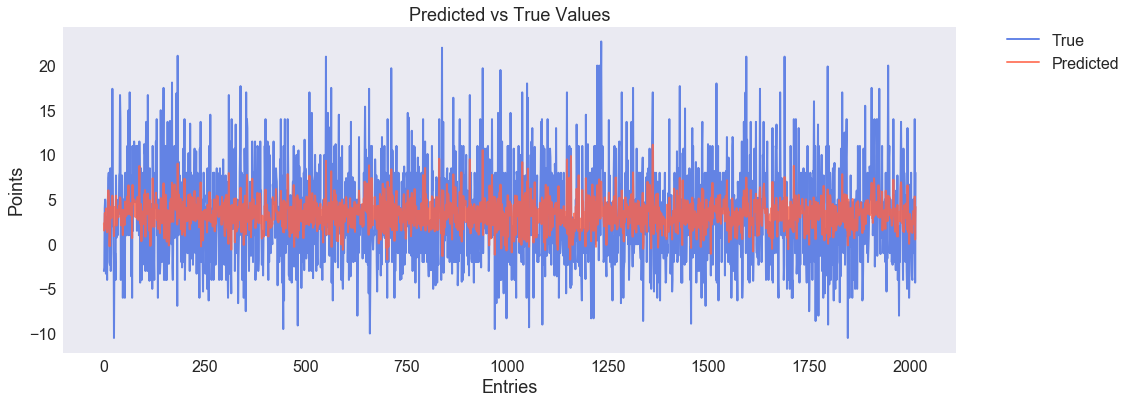

In [19]:
show_preds(xgb_1, X_1, y_1, df_1_all)

## Position 2

In [20]:
model_params_2 = df_2_all[base_params].mean()[df_2_all[base_params].mean() > 0.01].keys().values.tolist()

In [21]:
X_2 = df_2_all[model_params_2].values
y_2 = df_2_all['Points'].values

print(X_2.shape)
print(y_2.shape)

(4040, 149)
(4040,)


In [22]:
xgb_2 = xgboost.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=seed,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1, scoring='neg_mean_absolute_error')

In [23]:
cross_val(X_2, y_2, xgb_2)

MAE: 3.1482 (0.1431)
MSE: 16.3038 (1.6692)
-----------------------------------------


In [24]:
xgb_2.fit(X_2, y_2)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       scoring='neg_mean_absolute_error', seed=None, silent=True,
       subsample=1)

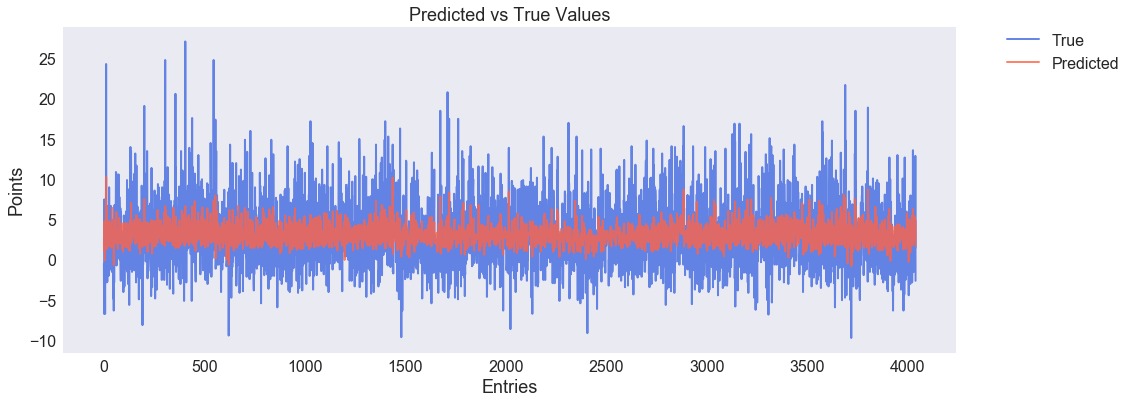

In [25]:
show_preds(xgb_2, X_2, y_2, df_2_all)

## Position 3

In [26]:
model_params_3 = df_3_all[base_params].mean()[df_3_all[base_params].mean() > 0.01].keys().values.tolist()

In [27]:
X_3 = df_3_all[model_params_3].values
y_3 = df_3_all['Points'].values

print(X_3.shape)
print(y_3.shape)

(4126, 149)
(4126,)


In [28]:
xgb_3 = xgboost.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=seed,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1, scoring='neg_mean_absolute_error')

In [29]:
cross_val(X_3, y_3, xgb_3)

MAE: 2.9649 (0.1031)
MSE: 14.3270 (0.8760)
-----------------------------------------


In [30]:
xgb_3.fit(X_3, y_3)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       scoring='neg_mean_absolute_error', seed=None, silent=True,
       subsample=1)

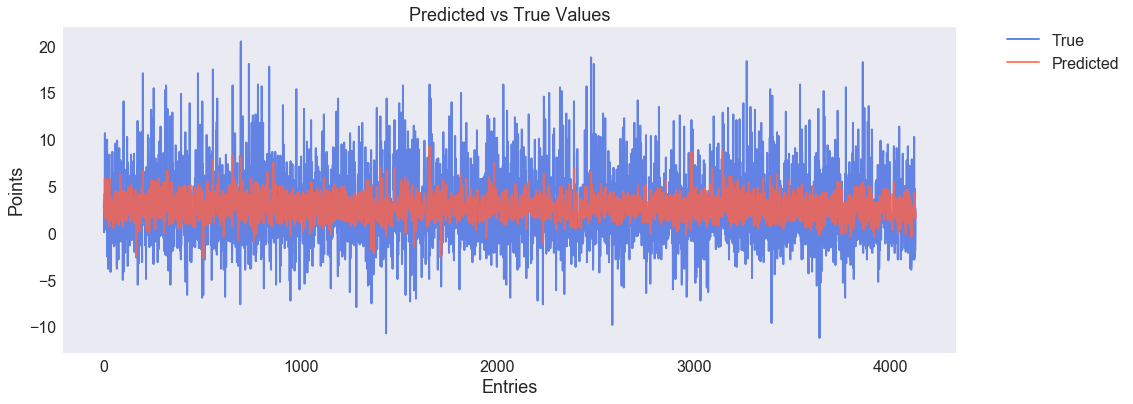

In [31]:
show_preds(xgb_3, X_3, y_3, df_3_all)

## Position 4

In [32]:
model_params_4 = df_4_all[base_params].mean()[df_4_all[base_params].mean() > 0.01].keys().values.tolist()

In [33]:
X_4 = df_4_all[model_params_4].values
y_4 = df_4_all['Points'].values

print(X_4.shape)
print(y_4.shape)

(9736, 150)
(9736,)


In [34]:
xgb_4 = xgboost.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=seed,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1, scoring='neg_mean_absolute_error')

In [35]:
cross_val(X_4, y_4, xgb_4)

MAE: 2.7757 (0.0256)
MSE: 13.8242 (0.0840)
-----------------------------------------


In [36]:
xgb_4.fit(X_4, y_4)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       scoring='neg_mean_absolute_error', seed=None, silent=True,
       subsample=1)

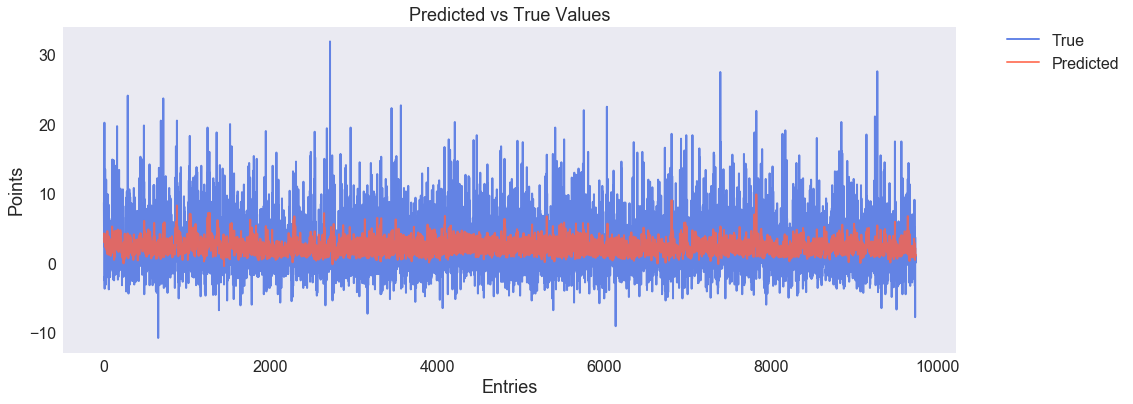

In [37]:
show_preds(xgb_4, X_4, y_4, df_4_all)

## Position 5

In [38]:
model_params_5 = df_5_all[base_params].mean()[df_5_all[base_params].mean() > 0.01].keys().values.tolist()

In [39]:
X_5 = df_5_all[model_params_5].values
y_5 = df_5_all['Points'].values

print(X_5.shape)
print(y_5.shape)

(6516, 150)
(6516,)


In [40]:
xgb_5 = xgboost.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=seed,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1, scoring='neg_mean_absolute_error')

In [41]:
cross_val(X_5, y_5, xgb_5)

MAE: 3.3082 (0.0885)
MSE: 20.0875 (1.6018)
-----------------------------------------


In [42]:
xgb_5.fit(X_5, y_5)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       scoring='neg_mean_absolute_error', seed=None, silent=True,
       subsample=1)

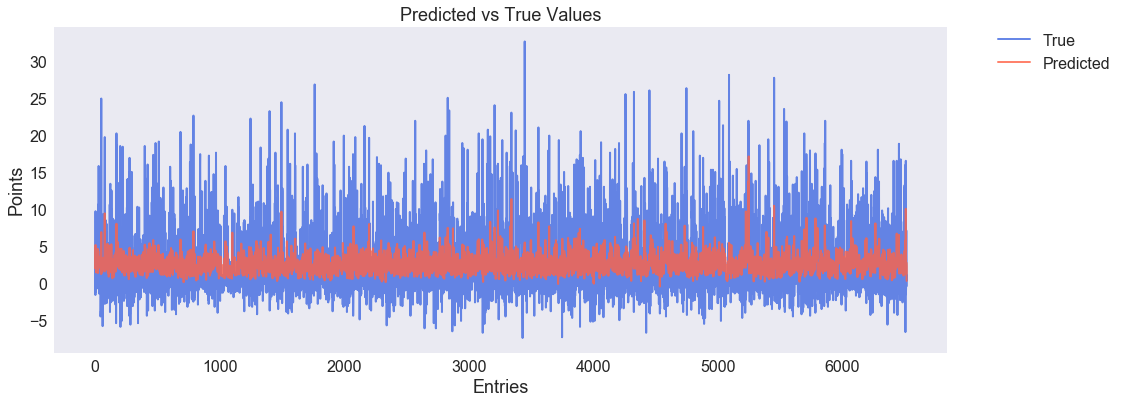

In [43]:
show_preds(xgb_5, X_5, y_5, df_5_all)

## Position 6

For Position 6, since there is only one player for the position, I remove the values associated to the team average for the position, as they end up being a duplicate feature.

In [44]:
model_params_6 = df_6_all[base_params].mean()[df_6_all[base_params].mean() > 0.01].keys().values.tolist()

In [45]:
model_params_6 = [e for e in model_params_6 if e not in (
    'avg_team_avg_6_Points', 'avg_team_avg_6_Price')]

In [46]:
X_6 = df_6_all[model_params_6].values
y_6 = df_6_all['Points'].values

print(X_6.shape)
print(y_6.shape)

(2022, 136)
(2022,)


In [47]:
xgb_6 = xgboost.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=seed,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1, scoring='neg_mean_absolute_error')

In [48]:
cross_val(X_6, y_6, xgb_6)

MAE: 1.6458 (0.0754)
MSE: 4.1235 (0.3457)
-----------------------------------------


In [49]:
xgb_6.fit(X_6, y_6)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       scoring='neg_mean_absolute_error', seed=None, silent=True,
       subsample=1)

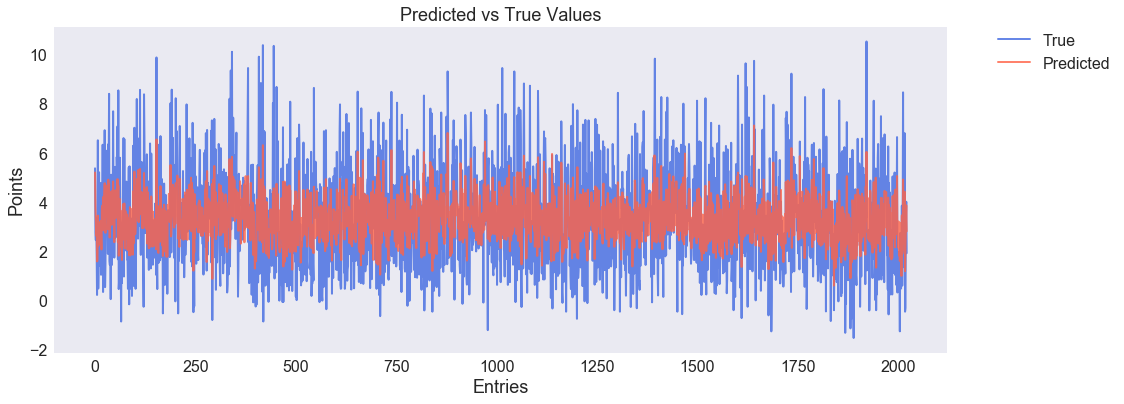

In [50]:
show_preds(xgb_6, X_6, y_6, df_6_all)

# Model Tuning

For the model tuning portion for the XGBoost models, the following steps are taken:
1. A parameter grid is established with ranges for the chosen hyperparameters.
2. A GridSearchCV is created with the associated parameter grid.
3. The model is fitted to the data.
4. The best parameters from the grid are selected and implemented on a modified model.
5. This new model is cross validated, fitted, and graphed, similarly to the original baseline model implementation. 

This process is repeated for every position.

In [51]:
# Parameter Grid Definition
max_depth = [4,5,6]
min_child_weight = [1,2,3]
subsample = [0.5, 1]
colsample_bytree = [0.5,1]
n_estimators = [200,400,600]

learning_rate = [0.01]
        
param_grid = {"max_depth": max_depth, "min_child_weight": min_child_weight,
              "subsample": subsample, "colsample_bytree" :colsample_bytree,
              "n_estimators": n_estimators, "learning_rate" :learning_rate}

## Position 1

In [52]:
# Create an estimator object with the estimator and parameter candidates.
kfold = KFold(n_splits=5, random_state=seed, shuffle = True)
xgb_1_GS = GridSearchCV(estimator=xgboost.XGBRegressor(random_state = seed), param_grid=param_grid, n_jobs=-1, scoring='neg_mean_absolute_error', cv=kfold, verbose=1)

In [53]:
xgb_1_GS.fit(X_1, y_1)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 21.0min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed: 29.1min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
       error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [4, 5, 6], 'min_child_weight': [1, 2, 3], 'subsample': [0.5, 1], 'colsample_bytree': [0.5, 1], 'n_estimators': [200, 400, 600], 'learning_rate': [0.01]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=1)

In [54]:
xgb_1_GS.best_params_

{'colsample_bytree': 0.5,
 'learning_rate': 0.01,
 'max_depth': 6,
 'min_child_weight': 1,
 'n_estimators': 200,
 'subsample': 0.5}

In [72]:
xgb_1_mod = xgboost.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=seed,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.5, scoring='neg_mean_absolute_error')

In [73]:
cross_val(X_1, y_1, xgb_1_mod)

MAE: 4.5432 (0.1408)
MSE: 31.1795 (2.1219)
-----------------------------------------


In [74]:
xgb_1_mod.fit(X_1, y_1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       scoring='neg_mean_absolute_error', seed=None, silent=True,
       subsample=0.5)

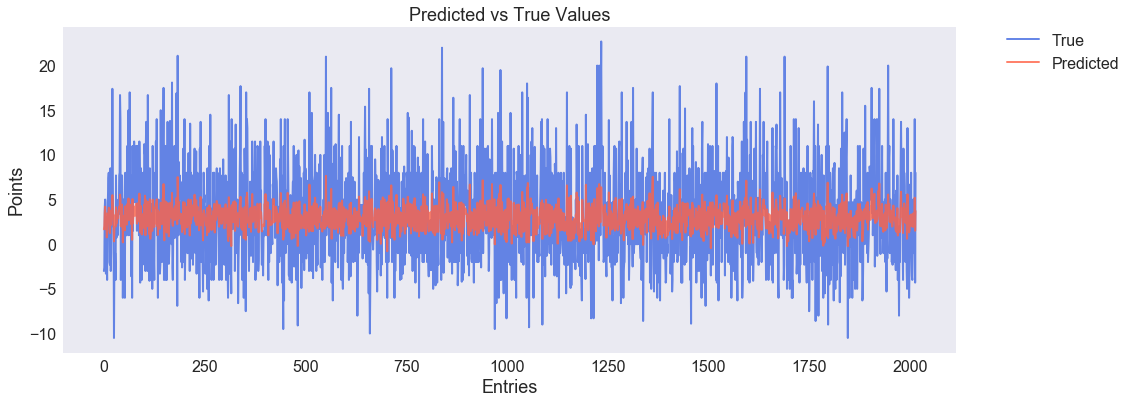

In [75]:
show_preds(xgb_1_mod, X_1, y_1, df_1_all)

## Position 2

In [55]:
# Create an estimator object with the estimator and parameter candidates.
kfold = KFold(n_splits=5, random_state=seed, shuffle = True)
xgb_2_GS = GridSearchCV(estimator=xgboost.XGBRegressor(random_state = seed), param_grid=param_grid, n_jobs=-1, scoring='neg_mean_absolute_error', cv=kfold, verbose=1)

In [56]:
xgb_2_GS.fit(X_2, y_2)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 38.5min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed: 54.2min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
       error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [4, 5, 6], 'min_child_weight': [1, 2, 3], 'subsample': [0.5, 1], 'colsample_bytree': [0.5, 1], 'n_estimators': [200, 400, 600], 'learning_rate': [0.01]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=1)

In [57]:
xgb_2_GS.best_params_

{'colsample_bytree': 1,
 'learning_rate': 0.01,
 'max_depth': 6,
 'min_child_weight': 2,
 'n_estimators': 400,
 'subsample': 0.5}

In [76]:
xgb_2_mod = xgboost.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=6, min_child_weight=2, missing=None, n_estimators=400,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=seed,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.5, scoring='neg_mean_absolute_error')

In [77]:
cross_val(X_2, y_2, xgb_2_mod)

MAE: 3.0779 (0.1355)
MSE: 15.8219 (1.5885)
-----------------------------------------


In [78]:
xgb_2_mod.fit(X_2, y_2)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=6, min_child_weight=2, missing=None, n_estimators=400,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       scoring='neg_mean_absolute_error', seed=None, silent=True,
       subsample=0.5)

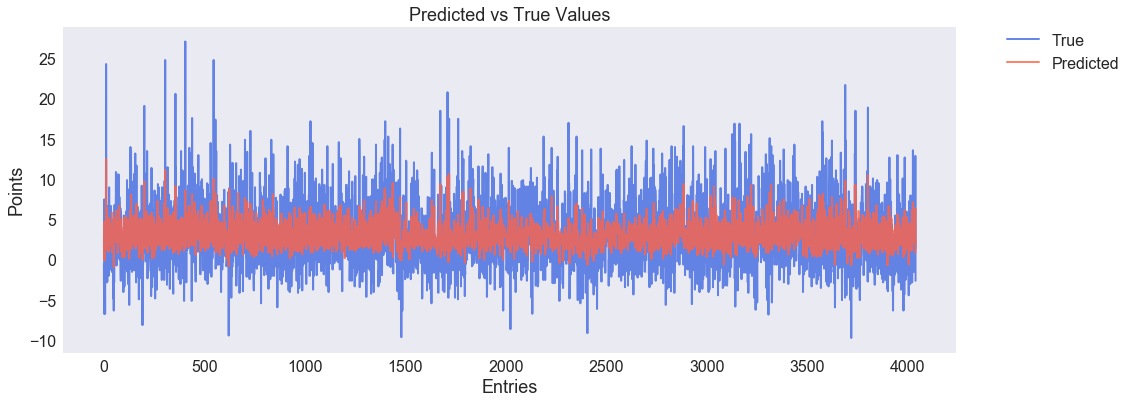

In [79]:
show_preds(xgb_2_mod, X_2, y_2, df_2_all)

## Position 3

In [58]:
# Create an estimator object with the estimator and parameter candidates.
kfold = KFold(n_splits=5, random_state=seed, shuffle = True)
xgb_3_GS = GridSearchCV(estimator=xgboost.XGBRegressor(random_state = seed), param_grid=param_grid, n_jobs=-1, scoring='neg_mean_absolute_error', cv=kfold, verbose=1)

In [59]:
xgb_3_GS.fit(X_3, y_3)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 13.0min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 40.8min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed: 55.5min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
       error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [4, 5, 6], 'min_child_weight': [1, 2, 3], 'subsample': [0.5, 1], 'colsample_bytree': [0.5, 1], 'n_estimators': [200, 400, 600], 'learning_rate': [0.01]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=1)

In [60]:
xgb_3_GS.best_params_

{'colsample_bytree': 1,
 'learning_rate': 0.01,
 'max_depth': 6,
 'min_child_weight': 1,
 'n_estimators': 600,
 'subsample': 0.5}

In [80]:
xgb_3_mod = xgboost.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=600,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=seed,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.5, scoring='neg_mean_absolute_error')

In [81]:
cross_val(X_3, y_3, xgb_3_mod)

MAE: 2.8444 (0.1159)
MSE: 13.7548 (0.9027)
-----------------------------------------


In [82]:
xgb_3_mod.fit(X_3, y_3)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=600,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       scoring='neg_mean_absolute_error', seed=None, silent=True,
       subsample=0.5)

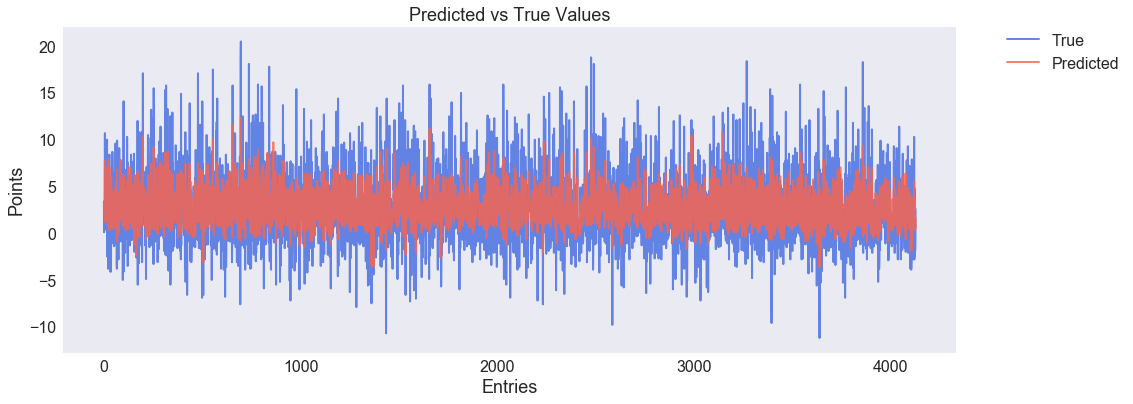

In [83]:
show_preds(xgb_3_mod, X_3, y_3, df_3_all)

## Position 4

In [61]:
# Create an estimator object with the estimator and parameter candidates.
kfold = KFold(n_splits=5, random_state=seed, shuffle = True)
xgb_4_GS = GridSearchCV(estimator=xgboost.XGBRegressor(random_state = seed), param_grid=param_grid, n_jobs=-1, scoring='neg_mean_absolute_error', cv=kfold, verbose=1)

In [62]:
xgb_4_GS.fit(X_4, y_4)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 21.5min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 76.2min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed: 104.8min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
       error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [4, 5, 6], 'min_child_weight': [1, 2, 3], 'subsample': [0.5, 1], 'colsample_bytree': [0.5, 1], 'n_estimators': [200, 400, 600], 'learning_rate': [0.01]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=1)

In [63]:
xgb_4_GS.best_params_

{'colsample_bytree': 1,
 'learning_rate': 0.01,
 'max_depth': 6,
 'min_child_weight': 2,
 'n_estimators': 200,
 'subsample': 0.5}

In [84]:
xgb_4_mod = xgboost.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=6, min_child_weight=2, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=seed,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.5, scoring='neg_mean_absolute_error')

In [85]:
cross_val(X_4, y_4, xgb_4_mod)

MAE: 2.7250 (0.0256)
MSE: 13.8443 (0.0837)
-----------------------------------------


In [86]:
xgb_4_mod.fit(X_4, y_4)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=6, min_child_weight=2, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       scoring='neg_mean_absolute_error', seed=None, silent=True,
       subsample=0.5)

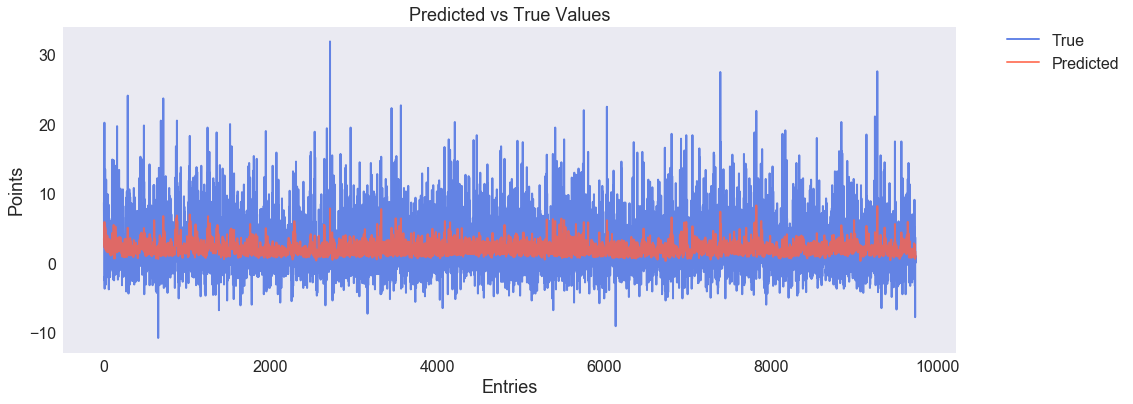

In [87]:
show_preds(xgb_4_mod, X_4, y_4, df_4_all)

## Position 5

In [66]:
# Create an estimator object with the estimator and parameter candidates.
kfold = KFold(n_splits=5, random_state=seed, shuffle = True)
xgb_5_GS = GridSearchCV(estimator=xgboost.XGBRegressor(random_state = seed), param_grid=param_grid, n_jobs=-1, scoring='neg_mean_absolute_error', cv=kfold, verbose=1)

In [67]:
xgb_5_GS.fit(X_5, y_5)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 15.8min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 58.8min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed: 84.5min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
       error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [4, 5, 6], 'min_child_weight': [1, 2, 3], 'subsample': [0.5, 1], 'colsample_bytree': [0.5, 1], 'n_estimators': [200, 400, 600], 'learning_rate': [0.01]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=1)

In [68]:
xgb_5_GS.best_params_

{'colsample_bytree': 1,
 'learning_rate': 0.01,
 'max_depth': 6,
 'min_child_weight': 3,
 'n_estimators': 200,
 'subsample': 0.5}

In [88]:
xgb_5_mod = xgboost.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=6, min_child_weight=3, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=seed,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.5, scoring='neg_mean_absolute_error')

In [89]:
cross_val(X_5, y_5, xgb_5_mod)

MAE: 3.2222 (0.0992)
MSE: 20.0498 (1.7313)
-----------------------------------------


In [90]:
xgb_5_mod.fit(X_5, y_5)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=6, min_child_weight=3, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       scoring='neg_mean_absolute_error', seed=None, silent=True,
       subsample=0.5)

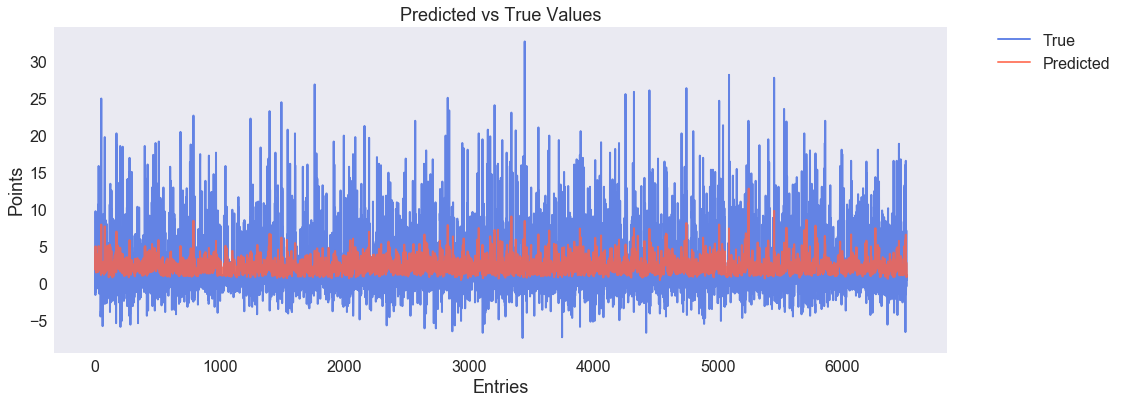

In [91]:
show_preds(xgb_5_mod, X_5, y_5, df_5_all)

## Position 6

In [69]:
# Create an estimator object with the estimator and parameter candidates.
kfold = KFold(n_splits=5, random_state=seed, shuffle = True)
xgb_6_GS = GridSearchCV(estimator=xgboost.XGBRegressor(random_state = seed), param_grid=param_grid, n_jobs=-1, scoring='neg_mean_absolute_error', cv=kfold, verbose=1)

In [70]:
xgb_6_GS.fit(X_6, y_6)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 19.9min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed: 28.0min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
       error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [4, 5, 6], 'min_child_weight': [1, 2, 3], 'subsample': [0.5, 1], 'colsample_bytree': [0.5, 1], 'n_estimators': [200, 400, 600], 'learning_rate': [0.01]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=1)

In [71]:
xgb_6_GS.best_params_

{'colsample_bytree': 0.5,
 'learning_rate': 0.01,
 'max_depth': 4,
 'min_child_weight': 1,
 'n_estimators': 400,
 'subsample': 0.5}

In [92]:
xgb_6_mod = xgboost.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=400,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=seed,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.5, scoring='neg_mean_absolute_error')

In [93]:
cross_val(X_6, y_6, xgb_6_mod)

MAE: 1.6219 (0.0668)
MSE: 3.9948 (0.3240)
-----------------------------------------


In [94]:
xgb_6_mod.fit(X_6, y_6)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=400,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       scoring='neg_mean_absolute_error', seed=None, silent=True,
       subsample=0.5)

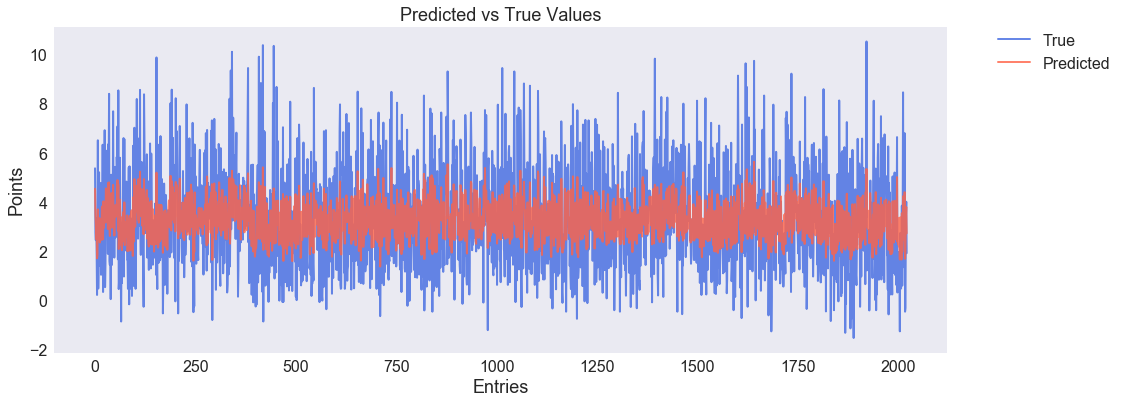

In [95]:
show_preds(xgb_6_mod, X_6, y_6, df_6_all)

# 2017 Season Results

Calculation of the season average score using the best performing Models for each position.

In [96]:
# All of the available rounds for the 2017 season.
list_rounds = df_1_2017['Round'].unique()

In [97]:
# For each position, get a list (more efficient working with lists than dataframes) 
# of the top predicted scoring athletes, using the established best performing models.
# The Team Formation is 4-4-2 with a coach (Position 6).

list1 = get_preds(df_1_2017, xgb_1_mod, model_params_1, 1)
print('List 1 done.')
list2 = get_preds(df_2_2017, xgb_2_mod, model_params_2, 2)
print('List 2 done.')
list3 = get_preds(df_3_2017, xgb_3_mod, model_params_3, 2)
print('List 3 done.')
list4 = get_preds(df_4_2017, xgb_4_mod, model_params_4, 4)
print('List 4 done.')
list5 = get_preds(df_5_2017, xgb_5_mod, model_params_5, 2)
print('List 5 done.')
list6 = get_preds(df_6_2017, xgb_6_mod, model_params_6, 1)
print('List 6 done.')

List 1 done.
List 2 done.
List 3 done.
List 4 done.
List 5 done.
List 6 done.


In [98]:
# Transform the lists with best choices for each position into a dataframe for easier calculations and visualizations.

columns = ['AthleteID', 'Position', 'Points', 'Round', 'Prediction', 'Price', 'Price_Variation']
df_ = pd.DataFrame(columns = columns)

list_total = []
print(len(list_total))

list_total = list1
print(len(list_total))
list_total.extend(list2)
print(len(list_total))
list_total.extend(list3)
print(len(list_total))
list_total.extend(list4)
print(len(list_total))
list_total.extend(list5)
print(len(list_total))
list_total.extend(list6)
print(len(list_total))

df_ = pd.DataFrame(list_total, columns= columns)

0
36
108
180
324
396
432


In [99]:
# Define what the cost for constructing the team was.
df_['Price_prev'] = df_['Price'] - df_['Price_Variation']

In [100]:
# Group the sum of scores per round.
df_sums = df_.groupby(['Round']).sum()

In [101]:
# Establish a Profit/Loss per round in 'Cartoletas' and what the acummulated value for these variations is per round.
df_sums['Profit'] = df_sums['Price'] - df_sums['Price_prev']
df_sums['Bank'] = df_sums['Profit'].cumsum()

The summary for each of the predicted rounds with their scores and added information.

In [102]:
df_sums

,AthleteID,Position,Points,Prediction,Price,Price_Variation,Price_prev,Profit,Bank
Round,,,,,,,,,
2,895806,43,61.9200,51.9202,163.1800,10.7400,152.4400,10.7400,10.7400
3,782633,43,57.1300,48.7230,155.5100,2.1200,153.3900,2.1200,12.8600
4,777820,43,53.7100,51.4048,164.4100,2.5000,161.9100,2.5000,15.3600
5,801738,43,80.4500,48.2753,155.2900,7.6500,147.6400,7.6500,23.0100
6,842076,43,64.2100,51.6741,152.7500,0.2000,152.5500,0.2000,23.2100
8,934917,43,56.2700,49.8243,154.5100,1.7300,152.7800,1.7300,24.9400
9,790173,43,77.5900,54.4271,178.2300,5.6400,172.5900,5.6400,30.5800
10,884734,43,47.2300,55.4118,144.6200,-2.3300,146.9500,-2.3300,28.2500
11,751821,43,85.7500,49.2313,155.0900,6.1700,148.9200,6.1700,34.4200


In [103]:
# Season 2017 Average
avg = df_sums.Points.sum()/df_sums.Points.count()
print('The 2017 Total Season Average Score was %.4f.' % (avg))

The 2017 Total Season Average Score was 52.6950.


### Average Scoring per Position

In [104]:
# Group the dataframe for each position (1-6) by their mean values.
df_mean = df_.groupby(['Position']).mean()

In [105]:
df_mean

,AthleteID,Points,Round,Prediction,Price,Price_Variation,Price_prev
Position,,,,,,,
1,56579.7500,3.3417,20.3611,3.9688,12.3414,0.1842,12.1572
2,71010.1250,4.1097,20.3611,4.9126,8.7968,0.3114,8.4854
3,66830.4722,3.5569,20.3611,4.6853,8.3376,0.0985,8.2392
4,65504.4444,4.7694,20.3611,3.5644,15.7943,-0.0985,15.8928
5,73504.6389,5.0986,20.3611,4.1828,14.5725,-0.1528,14.7253
6,67482.5556,4.7450,20.3611,4.3202,11.9964,0.2931,11.7033


## 2017 Season MAE Results

Calculation of the MAE results for the 2017 season.

In [106]:
from sklearn.metrics import mean_absolute_error

In [107]:
'''
Simple function for calculating the MAE for the given model, parameters, and dataframe.
'''
def get_test_score(model, df, params):
    preds = model.predict(df[params].as_matrix())
    err = mean_absolute_error(df['Points'], preds)
    print(err)

In [108]:
print('2017 MAE results:')
print('----------------------')
print('Position 1:')
get_test_score(xgb_1_mod, df_1_2017, model_params_1)
print('Position 2:')
get_test_score(xgb_2_mod, df_2_2017, model_params_2)
print('Position 3:')
get_test_score(xgb_3_mod, df_3_2017, model_params_3)
print('Position 4:')
get_test_score(xgb_4_mod, df_4_2017, model_params_4)
print('Position 5:')
get_test_score(xgb_5_mod, df_5_2017, model_params_5)
print('Position 6:')
get_test_score(xgb_6_mod, df_6_2017, model_params_6)

2017 MAE results:
----------------------
Position 1:
4.71814466217
Position 2:
3.2266788202
Position 3:
2.92757178202
Position 4:
2.90276251827
Position 5:
3.43396134021
Position 6:
1.59712523376


## Prediction Visualization

For visualizing the predictions as compared to the true values of the models, the following steps are taken:

1. The associated X and y are defined for the position and 2017 season.
2. A graph is shown for the given model, X, y, and data.

This process was repeated for the best performing models from the project.

### Position 6

In [114]:
X_6_2017 = df_6_2017[model_params_6].values
y_6_2017 = df_6_2017['Points'].values

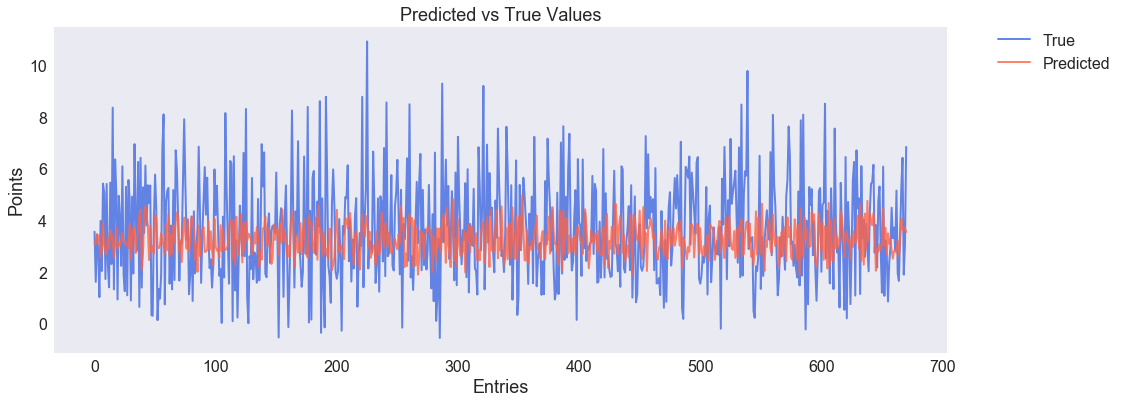

In [115]:
show_preds(xgb_6_mod, X_6_2017, y_6_2017, df_6_2017)

## Sensitivity Analysis

Following the identification of the best performing models for each position, the best performing XGB models were tested for their robustness.

In order to perform this Sensitivity Analysis, the following steps were taken:
1. The relevant training set was split into 100 different sets via train_test_split, using 20% of the data as the testing set.
2. The splits were trained and used to predict the test sets accordingly, recording the Mean Absolute error for each instance.
3. The distribution of the obtained MAE's was plotted and the average for all of the obtained MAE's was calculated.

This was repeated for all best performing models.

In [109]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [110]:
def get_errors(model, X, y):
    list_errs = []
    for i in range(100):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                            random_state=i)
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        err = mean_absolute_error(y_test, predictions)
        list_errs.append(err)
    return list_errs

### Position 6

In [111]:
errs_6 = get_errors(xgb_6_mod, X_6, y_6)

Text(0,0.5,'Distribution')

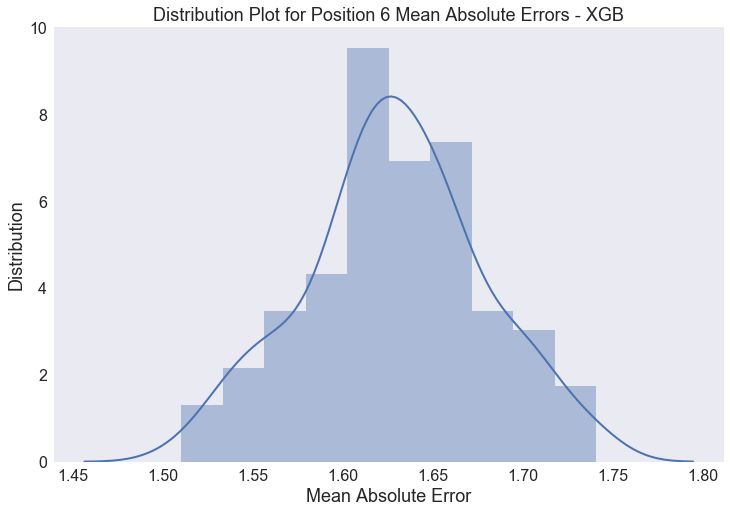

In [112]:
dist = sns.distplot(errs_6, axlabel='Mean Absolute Error')
dist.set_title('Distribution Plot for Position 6 Mean Absolute Errors - XGB')
dist.set_ylabel('Distribution')

In [113]:
np.mean(errs_6)

1.6290409152835092